# Evaluation plots Paul Holland

Like Fig. 1, Holland et al. (2014): Modeled mean ocean fields of:
-  barotropic streamfunction [contours every 10 Sv, magenta contour = 0 Sv (1 Sv ≡ 106 m3 s−1)];
-  winter [June–August (JJA)] mean mixed layer depth from KPP calculation (contours every 25 m, magenta contour = 100 m)
-  potential temperature at seabed (contours every 0.2°C, magenta contour = 0°C)
-  salinity at seabed (contours every 0.025, magenta contour = 34.65)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import glob
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.diagnostics import barotropic_streamfunction
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
run_folder  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test6/'
nemo_mesh   = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'
nemo_domain = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'

nemo_mesh = xr.open_dataset(nemo_mesh)

In [3]:
gridT_files = glob.glob(f'{run_folder}files/*grid_T*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
nemo_grid   = xr.open_dataset(gridT_files[0]) # load all the gridT files in the run folder

nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat',
                          'bounds_nav_lon_grid_T':'bounds_lon', 'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

In [5]:
# Select the NEMO variables we need and time-average    
dates_month = nemo_ds.time_counter.dt.month
nemo_winter = nemo_ds.isel(time_counter=((dates_month==6) | (dates_month==7) | (dates_month==8)))
MLD_winter  = nemo_winter['mldr10_1'].mean(dim='time_counter')

nemo_plot = xr.Dataset({'temp':nemo_ds['sbt'], 'salt':nemo_ds['sbs']}).mean(dim='time_counter')
nemo_plot = nemo_plot.assign({'MLD':MLD_winter})
nemo_plot = nemo_plot.rename({'x_grid_T_inner':'x', 'y_grid_T_inner':'y'})
# Apply NEMO land mask to all variables
nemo_plot = nemo_plot.where(nemo_plot['temp']!=0)

In [6]:
# Mask out anything beyond region of interest, plus ice shelf cavities
def apply_mask(data, nemo_mesh, mask_shallow=False):

    ice_mask = nemo_mesh.isel(time_counter=0).misf
    bathy    = nemo_mesh.isel(time_counter=0).bathy_metry
    
    data = data.where(ice_mask!=0)
    if mask_shallow:
        # Also mask anything shallower than 500m
        data = data.where(bathy >= 500)
    return data

In [10]:
# Barotropic streamfunction, interpolated to tracer grid
# ds_u = xr.open_dataset(f'{run_folder}files/eANT025.L121_1m_19790101_19791231_grid_U.nc').squeeze()
# ds_u = ds_u.rename({'e3u':'thkcello'})
# ds_v = xr.open_dataset(f'{run_folder}files/eANT025.L121_1m_19790101_19791231_grid_V.nc').squeeze()
# ds_v = ds_v.rename({'e3v':'thkcello'})

gridU_files = glob.glob(f'{run_folder}files/*grid_U*')[0]
gridV_files = glob.glob(f'{run_folder}files/*grid_V*')[0]
# ds_u = xr.open_mfdataset(gridU_files, chunks='auto').squeeze().rename({'e3u':'thkcello'})[['uo','thkcello']]
# ds_v = xr.open_mfdataset(gridV_files, chunks='auto').squeeze().rename({'e3v':'thkcello'})[['vo','thkcello']]
ds_u = xr.open_dataset(gridU_files).squeeze().rename({'e3u':'thkcello'})[['uo','thkcello']]
ds_v = xr.open_dataset(gridV_files).squeeze().rename({'e3v':'thkcello'})[['vo','thkcello']]

# strf = barotropic_streamfunction(ds_u, ds_v, nemo_domain, periodic=True, halo=True)

In [11]:
ds_domcfg = xr.open_dataset(nemo_domain).isel(time_counter=0)
strf = barotropic_streamfunction(ds_u, ds_v, ds_domcfg, periodic=True, halo=True)

In [12]:
strf_masked = apply_mask(strf, nemo_mesh, mask_shallow=False)
strf_mean   = strf_masked.mean(dim='time_counter')

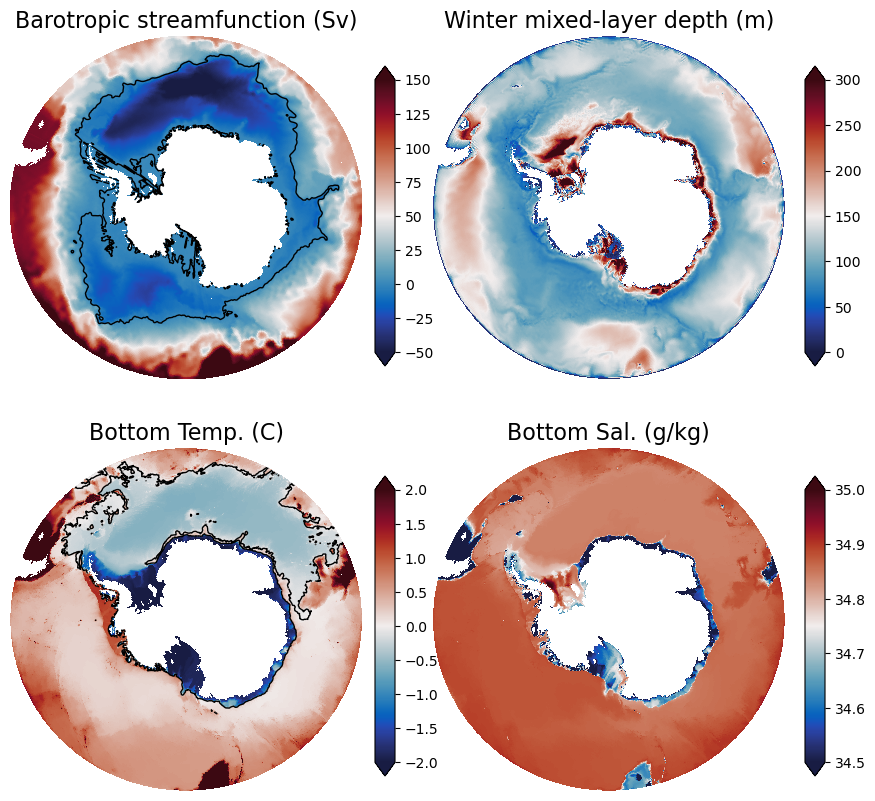

In [15]:
fig, ax = plt.subplots(2,2, figsize=(10,10), dpi=100)

args = {'masked':True, 'make_cbar':False, 'ctype':cmocean.cm.balance, 'shade_land':False}

img1 = circumpolar_plot(strf_mean, nemo_grid, ax=ax[0,0], title='Barotropic streamfunction (Sv)', contour=0, vmin=-50, vmax=150, **args)
img2 = circumpolar_plot(nemo_plot['MLD'], nemo_grid, ax=ax[0,1], title='Winter mixed-layer depth (m)', vmin=0, vmax=300, **args)
img3 = circumpolar_plot(nemo_plot['temp'], nemo_grid, ax=ax[1,0], title='Bottom Temp. (C)', contour=0, vmin=-2, vmax=2, **args)
img4 = circumpolar_plot(nemo_plot['salt'], nemo_grid, ax=ax[1,1], title='Bottom Sal. (g/kg)', vmin=34.5, vmax=35.0, **args)

cax1 = fig.add_axes([0.49, 0.55, 0.02, 0.3])
cax2 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
cax3 = fig.add_axes([0.49, 0.14, 0.02, 0.3])
cax4 = fig.add_axes([0.92, 0.14, 0.02, 0.3])
plt.colorbar(img1, cax=cax1, extend='both')
plt.colorbar(img2, cax=cax2, extend='both')
plt.colorbar(img3, cax=cax3, extend='both')
plt.colorbar(img4, cax=cax4, extend='both')